# Data

A) A  user  table  ( "takehome_users" )  with  data  on  12,000  users  who  signed  up  for  the
product  in  the  last  two  years.   This  table  includes:
* name:  the  user's  name
* object_id:   the  user's  id
* email:  email  address
* creation_source:   how  their  account  was  created.  This  takes  on  one
of  5  values:
    1. PERSONAL_PROJECTS:  invited  to  join  another  user's
personal  workspace
    2. GUEST_INVITE:  invited  to  an  organization  as  a  guest
(limited  permissions)
    3. ORG_INVITE:  invited  to  an  organization  (as  a  full  member)
    4. SIGNUP:  signed  up  via  the  website
    5. SIGNUP_GOOGLE_AUTH:  signed  up  using  Google
Authentication  (using  a  Google  email  account  for  their  login
id)
* creation_time:  when  they  created  their  account
* last_session_creation_time:   unix  timestamp  of  last  login
* opted_in_to_mailing_list:  whether  they  have  opted  into  receiving
marketing  emails
* enabled_for_marketing_drip:  whether  they  are  on  the  regular
marketing  email  drip
* org_id:   the  organization  (group  of  users)  they  belong  to
* invited_by_user_id:   which  user  invited  them  to  join  (if  applicable).


B) A  usage  summary  table  ( "takehome_user_engagement" )  that  has  a  row  for  each  day
that  a  user  logged  into  the  product.

# Question
Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven­day  period ,  identify  which  factors  predict  future  user
adoption .

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# %matplotlib notebook
%matplotlib inline
plt.style.use('ggplot')

### Engagement data
Recover adopted users

In [2]:
# read engagement data
df_log = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])

In [3]:
df_log.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


Make sure visited column is only filled with ones.
It does because sum matches the number of rows

In [5]:
df_log.visited.sum()

207917

We know we have 12,000 users. However, there are ~8.8k users with engagement history. That gives us an idea of our upper limit for retained users.

In [6]:
# number of user with activity
df_log.user_id.value_counts().count()

8823

Keep datetime precision to days.

In [7]:
# truncate datetime to day precision
df_log.time_stamp = df_log.time_stamp.values.astype('<M8[D]')
# using numpy is 3x faster
# df_log.time_stamp = df_log.time_stamp.floor('D')

In [8]:
# remove duplicates (same day logins count as one)
# FYI: there were no duplicates!
df_log = df_log.drop_duplicates()

Derive period of time between 3 consecutives logins

In [9]:
# move time stamp by 2 dates
df_log['post_date'] = df_log.groupby('user_id').time_stamp.shift(periods=2)

In [10]:
# make the difference between post_date and timestamp
df_log['period_days'] = (df_log.time_stamp - df_log.post_date).astype('timedelta64[D]') + 1

`Period_days` shows the time period in days where a user has logged in 3 times.

In [11]:
# capture adopted users
s_userid_adopted = df_log.loc[ df_log.period_days <= 7 ,'user_id']

In [12]:
# remove duplicate user id (users who logged on 3 days within a 7 days period multiple times)
s_userid_adopted = s_userid_adopted.drop_duplicates()

In [13]:
# number of users retained
num_users_adopted = s_userid_adopted.count()
print('Number of users adopted: {} ({:.1f}%)'.format(num_users_adopted, num_users_adopted/12000*100))

Number of users adopted: 1602 (13.4%)


In [14]:
# index means nothing, values are adopted user_id 
s_userid_adopted.head()

9       2
27     10
312    20
331    33
354    42
Name: user_id, dtype: int64

### Feature Engineering
What can we use to feed our model and reveal useful insight.

In [15]:
# need latin encoding because of '@' from email address
df_users = pd.read_csv('takehome_users.csv', index_col='object_id', parse_dates=['creation_time'], encoding='latin')

In [16]:
df_users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [17]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 937.5+ KB


In [18]:
# convert unix time to datetime
df_users.last_session_creation_time = pd.to_datetime(df_users.last_session_creation_time, unit='s')
# convert organization id to category
df_users.org_id = df_users.org_id.astype('category')

In [19]:
# fill last session missing date with creation date
crit_lastsession = df_users.last_session_creation_time.isnull()
df_users.loc[crit_lastsession, 'last_session_creation_time'] = df_users.loc[crit_lastsession, 'creation_time']

In [20]:
# compute number of days elapsed since creation
df_users['elapsed_days'] = (df_users.last_session_creation_time - df_users.creation_time)\
                                    .astype('timedelta64[D]').astype('int64')

In [21]:
# convert invited by user to a boolean
# is_invited is true if a user was invited by another user
df_users['is_invited'] = df_users.invited_by_user_id.notnull()

In [22]:
# number of users invited by each user
s_numinvited = df_users.invited_by_user_id.value_counts()
s_numinvited = s_numinvited.rename('num_invitation')

In [23]:
s_numinvited.head()

10741.0    13
2527.0     12
2308.0     11
1525.0     11
11770.0    11
Name: num_invitation, dtype: int64

In [24]:
# add number of invitation column to main dataframe
df_users = pd.concat([df_users, s_numinvited], axis = 1)
# replace Nan by 0 for number of invitation
df_users.num_invitation = df_users.num_invitation.fillna(0)

In [25]:
# add target column to our dataframe
df_users['is_adopted'] = df_users.index.isin(s_userid_adopted.values)

Remove uncessary columns (name, email, creation_time, last_session_creation_time, invited_by_user_id)

In [26]:
df_users = df_users.drop(['name', 'email', 'creation_time', 'last_session_creation_time', 'invited_by_user_id'], axis = 1)

Too many organization ids! Not sure how to group them so I would remove this feature for now.

In [27]:
df_users.org_id.value_counts().count()

417

In [28]:
# remove org id
df_users = df_users.drop('org_id', axis = 1)

In [29]:
# encode categorical features
df_users = pd.get_dummies(df_users, drop_first=True)

In [30]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 10 columns):
opted_in_to_mailing_list              12000 non-null int64
enabled_for_marketing_drip            12000 non-null int64
elapsed_days                          12000 non-null int64
is_invited                            12000 non-null bool
num_invitation                        12000 non-null float64
is_adopted                            12000 non-null bool
creation_source_ORG_INVITE            12000 non-null uint8
creation_source_PERSONAL_PROJECTS     12000 non-null uint8
creation_source_SIGNUP                12000 non-null uint8
creation_source_SIGNUP_GOOGLE_AUTH    12000 non-null uint8
dtypes: bool(2), float64(1), int64(3), uint8(4)
memory usage: 539.1 KB


### Modeling

In [31]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.pipeline import Pipeline

In [32]:
# get target values
y = df_users.is_adopted.values
X = df_users.drop(labels='is_adopted', axis = 1).values

# keep test set
X_train, X_test, y_train, y_test = \
            train_test_split( X , y, test_size = 0.2, random_state = 7, stratify = y)

In [33]:
log_clf = Pipeline([
                       ('scaler', MinMaxScaler()),
                       ('clf', LogisticRegression(penalty='l1', random_state=7, class_weight='balanced')),
                    ])

# paramter grid search
parameters = [
              {
              'clf__C': [0.01, 0.02, 0.03, 0.04],
              }
            ]

# set up grid search
gs_clf = GridSearchCV(log_clf, param_grid = parameters, cv = 5 , scoring='f1' , n_jobs = -1, verbose = 3)

In [34]:
# perform grid search CV on pipeline
_ = gs_clf.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:    1.9s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.9s finished
c:\programdata\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [35]:
gs_clf.best_params_

{'clf__C': 0.03}

In [36]:
# show classification report
y_train_pred = gs_clf.predict(X_train)
print(classification_report(y_train, y_train_pred, target_names=["not adopted", "adopted"]))

             precision    recall  f1-score   support

not adopted       0.98      0.99      0.98      8318
    adopted       0.90      0.89      0.90      1282

avg / total       0.97      0.97      0.97      9600



In [37]:
# show classification report
y_pred = gs_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["not adopted", "adopted"]))

             precision    recall  f1-score   support

not adopted       0.98      0.99      0.99      2080
    adopted       0.93      0.90      0.91       320

avg / total       0.98      0.98      0.98      2400



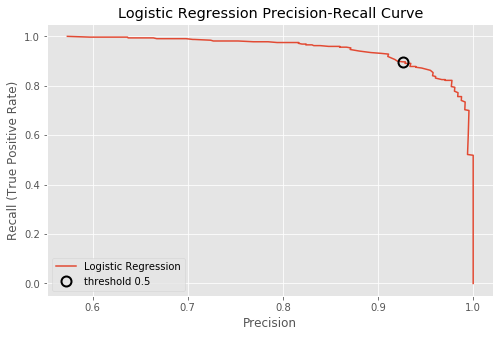

In [38]:
y_pred_prob = gs_clf.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
close_zero = np.argmin(np.abs(thresholds-0.5))

_ , axpr = plt.subplots(figsize = (8, 5))
# plot precision-recall
axpr.plot(precision, recall, label='Logistic Regression')
axpr.set_xlabel('Precision')
axpr.set_ylabel('Recall (True Positive Rate)')
axpr.set_title('Logistic Regression Precision-Recall Curve')
# plot zero threshold
axpr.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold 0.5", fillstyle="none", c='k', mew=2)
# mew: markeredgewidth
_ = plt.legend()

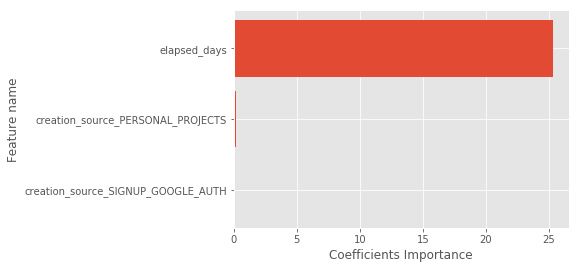

In [39]:
# get column names except target
names = df_users.drop(labels='is_adopted', axis = 1).columns

# get coefficient of logistic regression model
log_coef = gs_clf.best_estimator_.named_steps['clf'].coef_
# flatten it
log_coef = np.abs(log_coef.ravel())
# get indices for sorting in descending order
indsorted = log_coef.argsort()[::-1]
# apply indices to names and coeff
names = names[indsorted[:3]]
log_coef = log_coef[indsorted[:3]]
y_pos = range(len(names))

# make plot
figimp , aximp = plt.subplots()
aximp.barh(y_pos, log_coef)
aximp.set_yticks(y_pos)
aximp.set_yticklabels(names)
aximp.set_ylabel('Feature name')
aximp.set_xlabel('Coefficients Importance')
aximp.invert_yaxis()

# Conclusion

Loyal customers (long elapsed days) who were invited to join another user's personal workspace and used their google account as credential have a higher chance to become "adopted"!

### Extra

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
rf_clf = Pipeline([
                       ('scaler', MinMaxScaler()),
                       ('clf', RandomForestClassifier( random_state=7, class_weight='balanced_subsample')),
                    ])

# paramter grid search
parameters = [
              {
              'clf__n_estimators': [10, 50, 100],
              'clf__min_samples_leaf': [2,4,6],
              'clf__max_depth': [10, 15, 20],
              }
            ]

# set up grid search
gs_rf = GridSearchCV(rf_clf, param_grid = parameters, cv = 5 , scoring='f1' , n_jobs = -1, verbose = 3)

In [42]:
# perform grid search CV on pipeline
_ = gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    9.4s finished
c:\programdata\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [43]:
gs_rf.best_params_

{'clf__max_depth': 15, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 50}

In [44]:
# recover estimator from grid search (best estimator as it refit it at the end)
# [t.tree_.max_depth for t in gs_rf.best_estimator_.named_steps['clf'].estimators_]

In [45]:
# show classification report
y_train_pred = gs_rf.predict(X_train)
print(classification_report(y_train, y_train_pred, target_names=["not adopted", "adopted"]))

             precision    recall  f1-score   support

not adopted       1.00      0.97      0.99      8318
    adopted       0.86      0.99      0.92      1282

avg / total       0.98      0.98      0.98      9600



In [46]:
# show classification report
y_pred = gs_rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["not adopted", "adopted"]))

             precision    recall  f1-score   support

not adopted       0.99      0.97      0.98      2080
    adopted       0.85      0.94      0.89       320

avg / total       0.97      0.97      0.97      2400

